In [1]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm

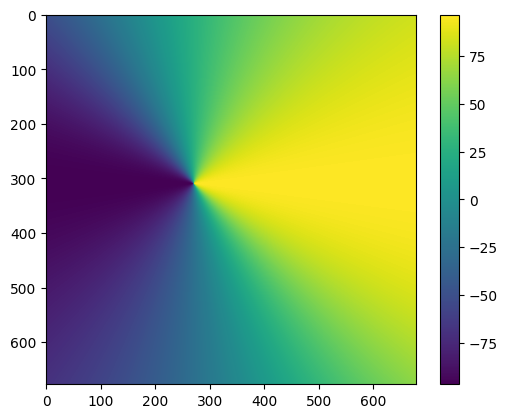

In [2]:
#checking the vaildity of the source plane map

import matplotlib.pyplot as plt
%matplotlib inline


# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel

# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
kwargs_sie = {'theta_E': 100, 'e1':0, 'e2':0.4, 'center_x': 270, 'center_y': 310}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
x_grid, y_grid = np.meshgrid(np.linspace(0, size-1, size), np.linspace(0, size-1, size))
# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape) #(y,x)
alpha_y_2d = alpha_y.reshape(x_grid.shape) #(y,x)


plt.imshow(alpha_x_2d)
plt.colorbar()


3


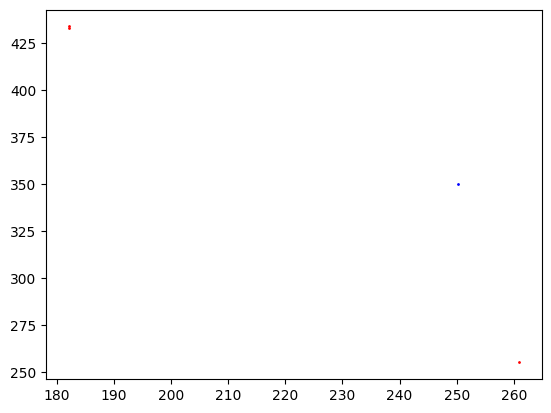

In [3]:
# Assuming alpha_y_2d and alpha_x_2d are defined and 'size' is known
coord = (250.3,350.0)
coord_x_r, coord_y_r = coord[0] % 1, coord[1] % 1
y_round, x_round = round(coord[1]), round(coord[0])

# Pre-calculate possible matching rounded values for efficiency
y_possible_rounds = {y_round, y_round - 1} if coord_y_r == 0.5 else {y_round}
x_possible_rounds = {x_round, x_round - 1} if coord_x_r == 0.5 else {x_round}

coordinates = []
n = 0

# Iterate over a pre-defined range, assuming alpha_y_2d and alpha_x_2d are indexed appropriately
for i in range(size):
    for j in range(size):
        ycoord, xcoord = i - alpha_y_2d[i, j], j - alpha_x_2d[i, j]
        if round(ycoord) in y_possible_rounds and round(xcoord) in x_possible_rounds:
            coordinates.append((j, i))  # (x, y)
            n += 1

plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='r', s=1)
plt.scatter(coord[0], coord[1], c='b', s=1)
print(n)

Number of pixels: [1, 2]


(150.0, 450.0)

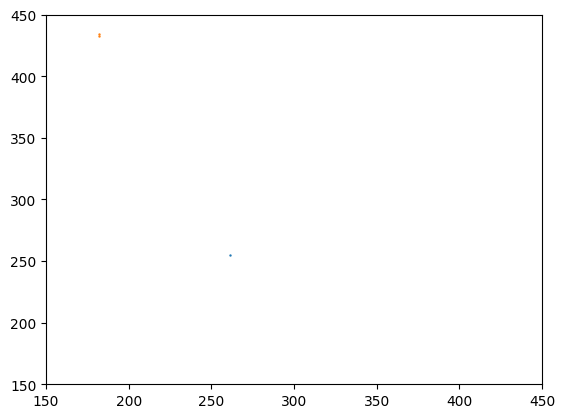

In [4]:
#Clustering
from sklearn.cluster import DBSCAN

coordinates = np.array(coordinates)

# Apply DBSCAN clustering
# eps and min_samples need to be chosen based on your specific data
dbscan = DBSCAN(eps=6, min_samples=1).fit(coordinates)

# Extract labels
labels = dbscan.labels_

# Separate coordinates into arrays for each image
images = {}
for label in set(labels):
    if label != -1:  # Ignore noise points
        images[f"Image_{label}"] = coordinates[labels == label]

# images now contains separate arrays for each detected image
# convert the dictionary images to list
images = list(images.values())

for i in range(0, len(images)):
    plt.scatter(images[i][:,0], images[i][:,1], s=0.5)

'''m=[]
for i in range(0, len(images)):
    mag = len(images[i])/len(circle_coords)
    m.append(mag)
print(f'Magnification: {m}')'''
print(f'Number of pixels: {[np.sum(len(images[i])) for i in range(0, len(images))]}')
plt.xlim(150,450)
plt.ylim(150,450)


In [5]:
# src or img pos?
def src_pos_test(img_guess, lensModel=lensModel):
    alpha_x, alpha_y = lensModel.alpha(img_guess[0], img_guess[1], kwargs_lens)
    return (img_guess[0]-alpha_x, img_guess[1]-alpha_y) #src guess
def diff (img_guess):
    return np.sqrt((src_pos_test(img_guess)[0]-coord[0])**2 + (src_pos_test(img_guess)[1]-coord[1])**2)

261 261 255 255 [260.72099337 254.82463258] 1.3110909767471276e-09
182 182 433 434 [182.34624616 433.51358634] 1.0077992446589395e-08


"from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver\n\n# specifiy the lens model class to deal with #\nsolver = LensEquationSolver(lensModel)\n\n# solve for image positions provided a lens model and the source position #\nimg_x, img_y = solver.image_position_analytical(coord[0],coord[1], kwargs_lens)\nprint(img_x, img_y)\nplt.scatter(img_x, img_y, c='r', s=100, marker='x')"

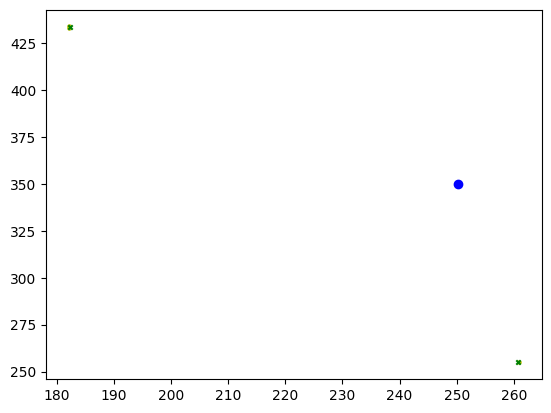

In [6]:
# minimum distance between the source position and the guess source positions deflected by mutiple images
# expect partition of the images and search for 1 sol for 1 image
plt.scatter(coord[0], coord[1], c='b')
plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='y', s=5)
# find maximum x and y coordinates of the image[i]
for i in range(len(images)):
    x_max, x_min = np.max(images[i][:,0]), np.min(images[i][:,0])
    y_max, y_min = np.max(images[i][:,1]), np.min(images[i][:,1])
    img_guess = np.random.uniform(x_min, x_max), np.random.uniform(y_min, y_max)
    pos = minimize(diff, img_guess, bounds =[(x_min-1, x_max+1), (y_min-1, y_max+1)], method='L-BFGS-B', tol=1e-8) # the 1 is for wider boundary
    print(x_min, x_max, y_min, y_max, pos.x, diff(pos.x))
    plt.scatter(pos.x[0], pos.x[1], c='g', s=10, marker='x')


'''from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

# specifiy the lens model class to deal with #
solver = LensEquationSolver(lensModel)

# solve for image positions provided a lens model and the source position #
img_x, img_y = solver.image_position_analytical(coord[0],coord[1], kwargs_lens)
print(img_x, img_y)
plt.scatter(img_x, img_y, c='r', s=100, marker='x')'''


In [7]:
# make a point source
coord = (250.3,350.0)
def find_rough_def_pix(coord):  
    coord_x_r, coord_y_r = coord[0] % 1, coord[1] % 1
    y_round, x_round = round(coord[1]), round(coord[0])

    # Pre-calculate possible matching rounded values for efficiency
    y_possible_rounds = {y_round, y_round - 1} if coord_y_r == 0.5 else {y_round}
    x_possible_rounds = {x_round, x_round - 1} if coord_x_r == 0.5 else {x_round}

    coordinates = []
    n = 0

    # Iterate over a pre-defined range, assuming alpha_y_2d and alpha_x_2d are indexed appropriately
    for i in range(size):
        for j in range(size):
            ycoord, xcoord = i - alpha_y_2d[i, j], j - alpha_x_2d[i, j]
            if round(ycoord) in y_possible_rounds and round(xcoord) in x_possible_rounds:
                coordinates.append((j, i))  # (x, y)
                n += 1

    #plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='r', s=1)
    #plt.scatter(coord[0], coord[1], c='b', s=1)
    
    return coordinates
coordinates = find_rough_def_pix(coord)


Number of pixels: [1, 2]


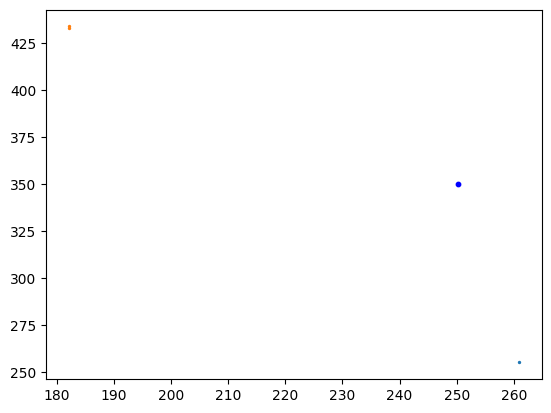

In [8]:
coordinates = np.array(coordinates)

#DBSCAN clustering

dbscan = DBSCAN(eps=3, min_samples=1).fit(coordinates)
labels = dbscan.labels_
images = {}
for label in set(labels):
    if label != -1:  # Ignore noise points
        images[f"Image_{label}"] = coordinates[labels == label]
images = list(images.values())

for i in range(0, len(images)):
    plt.scatter(images[i][:,0], images[i][:,1], s=2)
print(f'Number of pixels: {[np.sum(len(images[i])) for i in range(0, len(images))]}')
plt.scatter(coord[0], coord[1], c='b', s=10)



In [9]:
# interpolate the deflected angle given the image pos
def def_angle_test_interpolate(x,y, alpha_x= alpha_x_2d, alpha_y = alpha_y_2d):  #(x,y) is img_guess
    dx = x - floor(x)
    dy = y - floor(y)
    top_left = np.array([alpha_x[ceil(y), floor(x)], alpha_y[ceil(y), floor(x)]]) #to match (y,x) of alpha grid
    top_right = np.array([alpha_x[ceil(y), ceil(x)], alpha_y[ceil(y), ceil(x)]])
    bottom_left = np.array([alpha_x[floor(y), floor(x)], alpha_y[floor(y), floor(x)]])
    bottom_right = np.array([alpha_x[floor(y), ceil(x)], alpha_y[floor(y), ceil(x)]])
    top = top_left * (1 - dx) + top_right * dx
    bottom = bottom_left * (1 - dx) + bottom_right * dx
    alpha = top * dy + bottom *(1 - dy)
    src_guess = np.array([x-alpha[0], y-alpha[1]])
    return src_guess, alpha
                                             
def diff_interpolate (img_guess):
    src_guess = def_angle_test_interpolate(img_guess[0],img_guess[1])[0]
    return np.sqrt((src_guess[0]-coord[0])**2 + (src_guess[1]-coord[1])**2)


261 261 255 255 [260.72456372 254.82713788] 5.9279902226990615e-09
182 182 433 434 [182.34646382 433.51332542] 7.547510761974926e-09


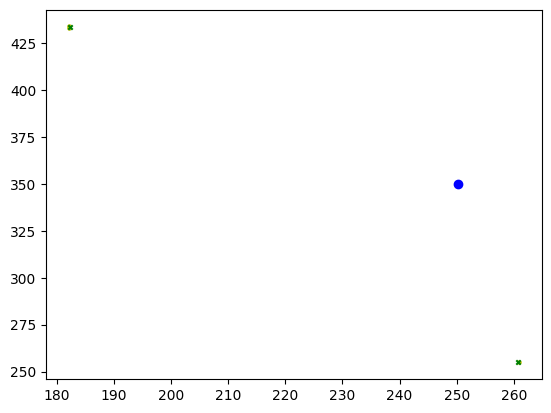

In [10]:
# minimum distance between the source position and the guess source positions deflected by mutiple images
# expect partition of the images and search for 1 sol for 1 image
plt.scatter(coord[0], coord[1], c='b')
plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='y', s=5)
# find maximum x and y coordinates of the image[i]
for i in range(len(images)):
    x_max, x_min = np.max(images[i][:,0]), np.min(images[i][:,0])
    y_max, y_min = np.max(images[i][:,1]), np.min(images[i][:,1])
    img_guess = np.random.uniform(x_min, x_max), np.random.uniform(y_min, y_max)
    pos = minimize(diff_interpolate, img_guess, bounds =[(x_min-1, x_max+1), (y_min-1, y_max+1)], method='L-BFGS-B', tol=1e-8) # the 1 is for wider boundary
    print(x_min, x_max, y_min, y_max, pos.x, diff_interpolate(pos.x))
    plt.scatter(pos.x[0], pos.x[1], c='g', s=10, marker='x')

    


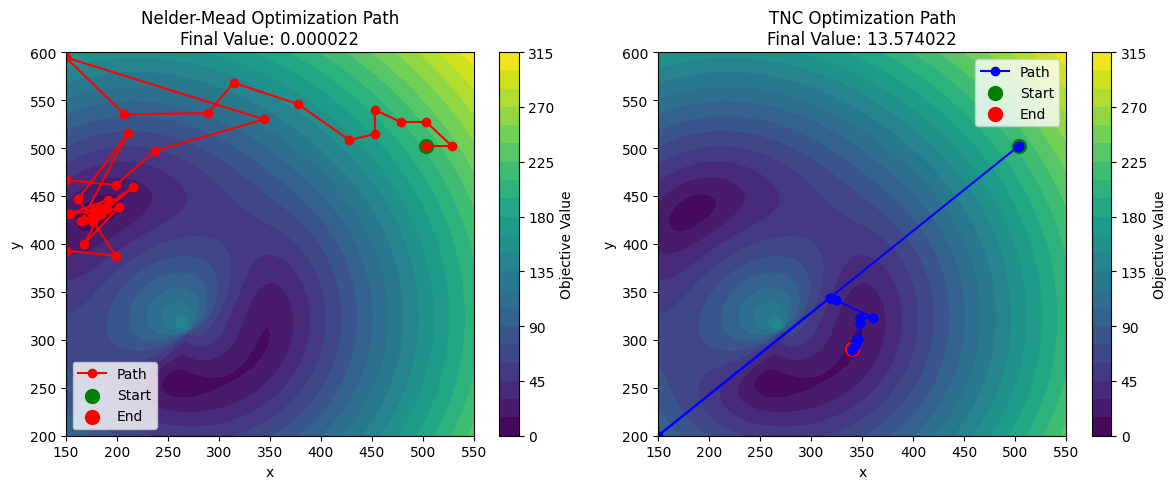

Nelder-Mead result: [182.34647622 433.51335417], value: 2.2163794646493197e-05
TNC result: [340.19591147 289.99999995], value: 13.574021569189949
(678, 678)


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def optimize_with_path(method, x0, bounds):
    path = [x0]
    
    def objective_wrapper(x):
        path.append(x)
        return diff_interpolate(x)
    
    result = minimize(objective_wrapper, x0, method=method, bounds=bounds)
    return result, np.array(path)

# Set up the problem
bounds = [(150, 550), (200, 600)]
x0 = np.random.uniform(bounds[0][0], bounds[0][1]), np.random.uniform(bounds[1][0], bounds[1][1])

# Run optimizations
nelder_mead_result, nelder_mead_path = optimize_with_path('Nelder-Mead', x0, bounds)
tnc_result, tnc_path = optimize_with_path('L-BFGS-B', x0, bounds)

# Create a contour plot of the objective function
x = np.linspace(bounds[0][0], bounds[0][1], 100)
y = np.linspace(bounds[1][0], bounds[1][1], 100)
X, Y = np.meshgrid(x, y)
Z = np.array([diff_interpolate([xi, yi]) for xi, yi in zip(X.ravel(), Y.ravel())]).reshape(X.shape)

# Plot
plt.figure(figsize=(12, 5))

# Nelder-Mead path
plt.subplot(121)
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(label='Objective Value')
plt.plot(nelder_mead_path[:, 0], nelder_mead_path[:, 1], 'ro-', label='Path')
plt.scatter(nelder_mead_path[0, 0], nelder_mead_path[0, 1], c='g', s=100, label='Start')
plt.scatter(nelder_mead_path[-1, 0], nelder_mead_path[-1, 1], c='r', s=100, label='End')
plt.title(f'Nelder-Mead Optimization Path\nFinal Value: {nelder_mead_result.fun:.6f}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# TNC path
plt.subplot(122)
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(label='Objective Value')
plt.plot(tnc_path[:, 0], tnc_path[:, 1], 'bo-', label='Path')
plt.scatter(tnc_path[0, 0], tnc_path[0, 1], c='g', s=100, label='Start')
plt.scatter(tnc_path[-1, 0], tnc_path[-1, 1], c='r', s=100, label='End')
plt.title(f'TNC Optimization Path\nFinal Value: {tnc_result.fun:.6f}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.tight_layout()
plt.show()

# Print results
print(f"Nelder-Mead result: {nelder_mead_result.x}, value: {nelder_mead_result.fun}")
print(f"TNC result: {tnc_result.x}, value: {tnc_result.fun}")
print(alpha_x_2d.shape)

(678, 678)
[468.07536116 542.17475401 560.97541182 544.12489872 352.59390224
  20.06279234 349.2528685  198.44468037 307.64446037 105.68935043
 583.15839092 465.31369263 147.97962215 548.39137294 119.89036983
  44.94339896 222.48293503 500.51260899 650.40312865  57.74802833
 343.93685396  63.32237767  58.84943978  33.49490062 397.60910011
 594.92317795 468.8952395  602.61733553 469.53261209 405.32915976
 542.18639676 487.79633708 323.19203755  32.60280922 417.28718633
 191.22772285 144.45123853 249.48235152  20.8936936  246.13505331
  95.08105914 396.68589612 352.38840339 228.35632604 415.63601742
 644.20898347 413.76387805 137.83889441 248.17283971  93.76897259
 298.70355798 647.46002706 392.82593428 137.07228674 477.10719947
  90.02382064 661.1287837  126.75107676 212.34240845 514.50493475
 289.91611343  49.52518906 308.88388978 394.97177766  91.12818874
 207.07562572 281.04091389 264.34022271 359.24215335  49.4422078
 136.51141638 260.47510548 141.23088222 498.45917336 244.59123949


100%|██████████| 600/600 [29:58<00:00,  3.00s/it]


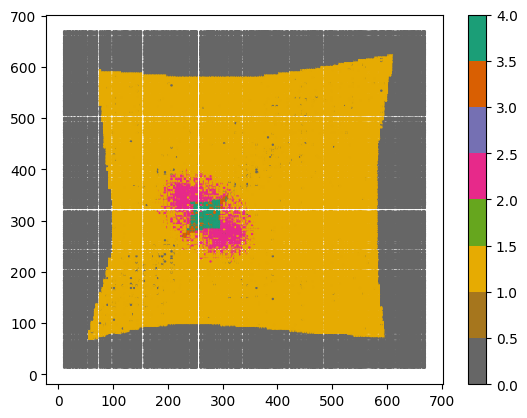

In [30]:
# coloring of number of images per pixel
size = 678
deflected_pix = [[[] for _ in range(size)] for _ in range(size)]
print(alpha_x_2d.shape)
for i in range(size):
    for j in range(size):
        ycoord, xcoord = i - alpha_y_2d[i, j], j - alpha_x_2d[i, j]
        if 0 <= round(ycoord) < size and 0 <= round(xcoord) < size:
            deflected_pix[round(xcoord)][round(ycoord)].append((j,i))
        

x_coloring = np.random.uniform(10,670, 600)
y_coloring = np.random.uniform(10,670, 600)
color =[]

for i in tqdm(x_coloring):
    for j in y_coloring:
        n=0
        coord = (i,j)
        
        coord_img = np.array(deflected_pix[round(i)][round(j)])
        #DBSCAN clustering
        if len(coord_img) == 0:
            color.append(n)
            continue
        dbscan = DBSCAN(eps=3, min_samples=1).fit(coord_img)
        labels = dbscan.labels_
        images = {}
        for label in set(labels):
            if label != -1:  # Ignore noise points
                images[f"Image_{label}"] = coord_img[labels == label]
        images = list(images.values())
        #print(images)
        
        # interpolate the deflected angle given the image pos
        for k in range(len(images)):
            x_max, x_min = np.max(images[k][:,0]), np.min(images[k][:,0])
            y_max, y_min = np.max(images[k][:,1]), np.min(images[k][:,1])
            img_guess = np.random.uniform(x_min, x_max), np.random.uniform(y_min, y_max)
            if x_max+1 < size and y_max+1 < size and x_min-1 > 0 and y_min-1 > 0:
                pos = minimize(diff_interpolate, img_guess, bounds =[(x_min-1, x_max+1), (y_min-1, y_max+1)], method='L-BFGS-B', tol=1e-7) # the 1 is for wider boundary
            #print (pos.x, diff_interpolate(pos.x))
            if diff_interpolate(pos.x) < 1e-6:
                n +=1
        color.append(n) 
          
coordinates =[(x, y) for x in x_coloring for y in y_coloring]
assert len(color) == len(coordinates), "Color array must match the number of points"

# Plot each point with its corresponding color
coordinates = np.array(coordinates)
color = np.array(color)
scatter = plt.scatter(coordinates[:, 0], coordinates[:, 1], c=color, cmap='Dark2_r', s=0.5)
  

plt.colorbar()  # Show color scale



In [13]:
# magnification and time delay given source and image positions
image_position = np.array([292.20972079, 424.95360025])
mag1 = lensModel.magnification(image_position[0], image_position[1], kwargs_lens)
print(f"Analytical magnification : {mag1}")
def calculate_magnification(theta, h=1e-7):
    """
    Calculate the magnification at a given image position theta.
    
    :param theta: Image position (2D numpy array)
    :param h: Step size for numerical differentiation
    :return: Magnification
    """
    # Compute partial derivatives

    def partial_derivative(func, var, point): 
        args = point[:]
        def wraps(x):
            args[var] = x
            return func(args)
        return lambda x: (wraps(x+h) - wraps(x-h))/(2*h) # central difference diff fct
    
    alpha = lambda t: def_angle_test_interpolate(t[0], t[1])[1]
    
    dalpha1_dtheta1 = partial_derivative(lambda t: alpha(t)[0], 0, theta)(theta[0])
    dalpha1_dtheta2 = partial_derivative(lambda t: alpha(t)[0], 1, theta)(theta[1])
    dalpha2_dtheta1 = partial_derivative(lambda t: alpha(t)[1], 0, theta)(theta[0])
    dalpha2_dtheta2 = partial_derivative(lambda t: alpha(t)[1], 1, theta)(theta[1])
    # Construct the magnification tensor
    A = np.array([
        [1 - dalpha1_dtheta1, -dalpha1_dtheta2],
        [-dalpha2_dtheta1, 1 - dalpha2_dtheta2]
    ])
    
    # Calculate magnification
    magnification = 1 / np.linalg.det(A)
    
    return magnification

# Example usage

mag = calculate_magnification(image_position)
print(f"Interpolation magnification at {image_position}: {mag}")



Analytical magnification : 6.377801163843745
Interpolation magnification at [292.20972059 424.95360005]: 6.422644346764919


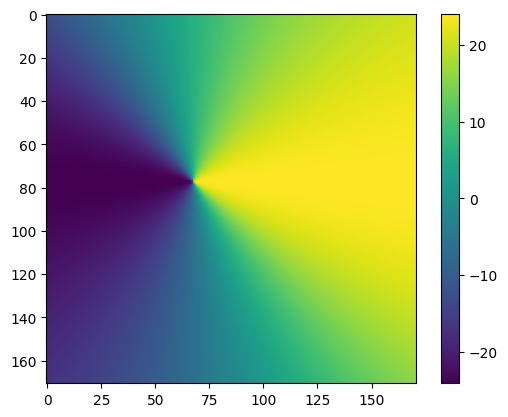

In [14]:
#verifying my method, ignore for now
# make the deflection angle map and the source position map in arcsec
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
kwargs_sie = {'theta_E': 25, 'e1':0, 'e2':0.4, 'center_x': 67.5, 'center_y': 77.5}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 170
x_grid, y_grid = np.meshgrid(np.linspace(0, size, size+1), np.linspace(0, size, size+1))
# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape) #(y,x)
alpha_y_2d = alpha_y.reshape(x_grid.shape) #(y,x)


plt.imshow(alpha_x_2d)
plt.colorbar()

In [ ]:
#dumb stuffs

# Assume you have precomputed deflection angle maps
coord_arc = (24,10)  # Convert to arcsec
x_grid, y_grid = np.linspace(0, size, size+1), np.linspace(0, size, size+1)

# Pixel grid information
# Generate flat grid arrays
alpha_x_T = alpha_x_2d.T
alpha_y_T = alpha_y_2d.T

# Define lens model using the InterpolatedDeflection class
lens_model_list = ['INTERPOL']

kwargs_interpol = {
    'f_x': alpha_x_2d,
    'f_y': alpha_y_2d,
    'grid_interp_x': x_grid,
    'grid_interp_y': y_grid,
}
print(x_flat, y_flat)
kwargs_len = [kwargs_interpol]

# Create the lens model
lens_model1 = LensModel(lens_model_list=lens_model_list)

# Define image position (arbitrary example)
theta_x, theta_y = (305.5, 345.4)
print(coord)
# Compute image positions
beta_x1, beta_y1 = lens_model1.ray_shooting(theta_x, theta_y, kwargs_len)
print(beta_x1, beta_y1)

from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
solver = LensEquationSolver(lens_model1)
src_x, src_y= solver.image_position_from_source(coord[0], coord[1], kwargs_lens= kwargs_len)
print(src_x, src_y)
